In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.spatial import cKDTree
from tqdm import tqdm
from matplotlib.patches import Ellipse

In [2]:
with open("../fits/gmm_vmp.pkl", "rb") as f:
    gmm_vmp = pickle.load(f)
with open("../fits/gmm_imp.pkl", "rb") as f:
    gmm_imp = pickle.load(f)

vphi_data = '../data/df_v_final.fits'
with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

def filter_metallicity_bin(df, min_mh, max_mh):
    return df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]

df_vmp = filter_metallicity_bin(df_v, -3, -2)
df_imp = filter_metallicity_bin(df_v, -2, -1.6)

In [ ]:
# Thick disc parameters (3D Gaussian)
disc_mean_3d = np.array([0, 180, 0]) 
disc_disp_3d = np.array([70, 50, 60]) 
disc_2sigma = 2 * disc_disp_3d[:2]  

def inside_ellipse(x, y, center, width, height):
    return ((x - center[0]) / width) ** 2 + ((y - center[1]) / height) ** 2 <= 1

def generate_mock_with_errors(gmm, obs_stars, obs_errors):
    mock_stars = gmm.draw(len(obs_stars))[:, :3]
    tree = cKDTree(obs_stars)
    _, idx = tree.query(mock_stars)
    assigned_errors = obs_errors[idx]
    noisy_mock = np.random.normal(mock_stars, assigned_errors)
    return noisy_mock

def compute_residual_map(df_bin, gmm, bins=100, vR_lim=(-400, 400), vphi_lim=(-400, 400)):
    obs_stars = df_bin[['v_R', 'v_phi', 'v_Z']].values
    obs_errors = df_bin[['v_R_uncertainty', 'v_phi_uncertainty', 'v_Z_uncertainty']].values
    mock_stars = generate_mock_with_errors(gmm, obs_stars, obs_errors)

    H_obs, xedges, yedges = np.histogram2d(obs_stars[:, 0], obs_stars[:, 1], bins=bins, range=[vR_lim, vphi_lim])
    H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=bins, range=[vR_lim, vphi_lim])

    H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)
    return H_residual, xedges, yedges

def assign_uncertainties(mock_stars, obs_stars, obs_errors):
    """Assign measurement uncertainties by nearest-neighbour matching in (v_R, v_phi, v_Z)."""
    tree = cKDTree(obs_stars)
    _, idx = tree.query(mock_stars)
    assigned_errors = obs_errors[idx]
    noisy_mock = np.random.normal(mock_stars, assigned_errors)
    return noisy_mock

def run_residual_analysis(df_bin, gmm, disc_fractions, n_realizations=200):
    obs_stars = df_bin[['v_R', 'v_phi', 'v_Z']].values
    obs_errors = df_bin[['v_R_uncertainty', 'v_phi_uncertainty', 'v_Z_uncertainty']].values

    # Compute observed disc residual (obs vs. baseline mock)
    obs_residuals = []
    for _ in tqdm(range(n_realizations), desc="Observed residual MC"):
        baseline_mock = gmm.draw(len(obs_stars))[:, :3]
        noisy_mock = assign_uncertainties(baseline_mock, obs_stars, obs_errors)
        obs_in_disc = np.sum(inside_ellipse(obs_stars[:, 0], obs_stars[:, 1], disc_mean_3d[:2], *disc_2sigma))
        mock_in_disc = np.sum(inside_ellipse(noisy_mock[:, 0], noisy_mock[:, 1], disc_mean_3d[:2], *disc_2sigma))
        residual = obs_in_disc - mock_in_disc
        obs_residuals.append(residual)
    obs_mean = np.mean(obs_residuals)
    obs_std = np.std(obs_residuals)

    # Compute injected mock disc residuals (mock+disc vs. GMM model)
    frac_means, frac_stds = [], []
    for frac in tqdm(disc_fractions, desc="Injected disc fractions"):
        mock_disc_residuals = []
        for _ in range(n_realizations):
            # Generate baseline mock 
            baseline_mock = gmm.draw(len(obs_stars))[:, :3]
            noisy_baseline = assign_uncertainties(baseline_mock, obs_stars, obs_errors)
            mock_in_disc = np.sum(inside_ellipse(noisy_baseline[:, 0], noisy_baseline[:, 1], disc_mean_3d[:2], *disc_2sigma))

            # Generate injected mock (with added disc stars)
            injected_mock = gmm.draw(len(obs_stars))[:, :3]
            n_inject = int(frac * len(obs_stars))
            if n_inject > 0:
                disc_stars = np.random.normal(disc_mean_3d, disc_disp_3d, size=(n_inject, 3))
                injected_mock = np.vstack([injected_mock, disc_stars])
            noisy_injected = assign_uncertainties(injected_mock, obs_stars, obs_errors)
            injected_in_disc = np.sum(inside_ellipse(noisy_injected[:, 0], noisy_injected[:, 1], disc_mean_3d[:2], *disc_2sigma))

            # Compute residual relative to baseline
            residual = injected_in_disc - mock_in_disc
            mock_disc_residuals.append(residual)

        frac_means.append(np.mean(mock_disc_residuals))
        frac_stds.append(np.std(mock_disc_residuals))  # Use std over realisations for full uncertainty

    return obs_mean, obs_std, frac_means, frac_stds

# Run VMP 
disc_fractions = np.array([0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05])
n_realizations = 200

print("\nComputing VMP...")
H_vmp, xedges, yedges = compute_residual_map(df_vmp, gmm_vmp)
results_vmp = run_residual_analysis(df_vmp, gmm_vmp, disc_fractions, n_realizations)

# Run IMP 
print("\nComputing IMP...")
H_imp, xedges, yedges = compute_residual_map(df_imp, gmm_imp)
results_imp = run_residual_analysis(df_imp, gmm_imp, disc_fractions, n_realizations)



Computing VMP...


Injected disc fractions: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]



Computing IMP...


Injected disc fractions: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


In [4]:
def plot_residual_map(H_residual, xedges, yedges, name, output_file):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.pcolormesh(xedges, yedges, H_residual.T, cmap='coolwarm', shading='auto', vmin=-1, vmax=1)
    
    ellipse = Ellipse(xy=(0, 180), width=2*70*2, height=2*50*2,  # width = 4σ_R, height = 4σ_phi
                  edgecolor='black', facecolor='none', linestyle='--', linewidth=2)
    ax.add_patch(ellipse)
    ax.set_xlabel('v_R (km/s)')
    ax.set_ylabel('v_phi (km/s)')
    ax.set_title(f"{name} Normalized Residual Map")
    ax.grid(True)
    fig.colorbar(im, ax=ax, orientation='vertical', label='Normalized Residual')

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

def plot_disc_fraction(disc_fractions, results, name, output_file):
    obs_mean, obs_std, frac_means, frac_stds = results

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.axhline(obs_mean, color='blue', linestyle='--', label='Observation result')
    ax.fill_between(disc_fractions, obs_mean - obs_std, obs_mean + obs_std, color='blue', alpha=0.3)
    ax.plot(disc_fractions, frac_means, color='black',marker='x', label='Mock star test')
    ax.fill_between(disc_fractions,
                    np.array(frac_means) - np.array(frac_stds),
                    np.array(frac_means) + np.array(frac_stds),
                    color='red', alpha=0.3)
    ax.set_xlabel('Disc fraction')
    ax.set_ylabel('Disc star residual')
    ax.set_ylim(-50, 250)
    ax.set_title(f"{name} Disc Residual vs. Disc Fraction")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()


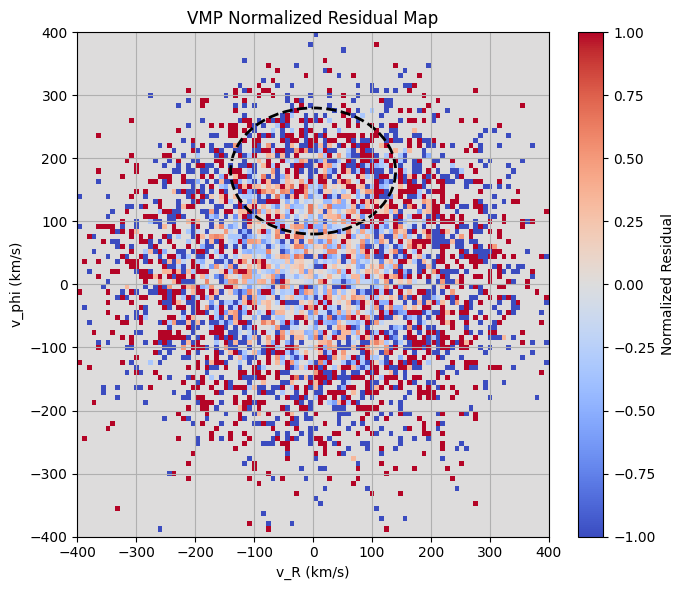

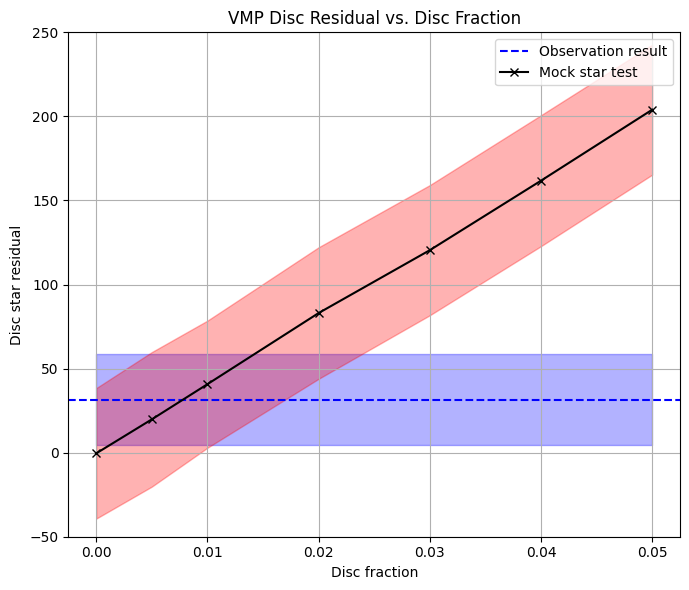

In [5]:
plot_residual_map(H_vmp, xedges, yedges, "VMP", "../figures/vmp_residual_map.png")
plot_disc_fraction(disc_fractions, results_vmp, "VMP", "../figures/vmp_disc_fraction.png")

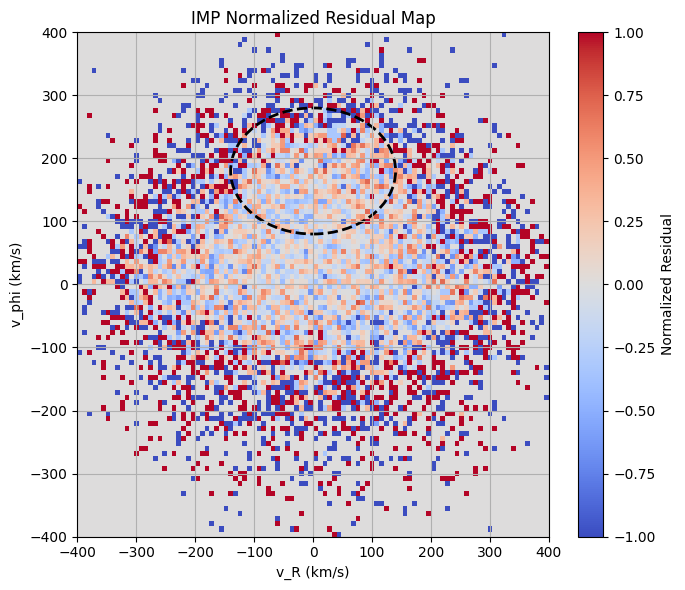

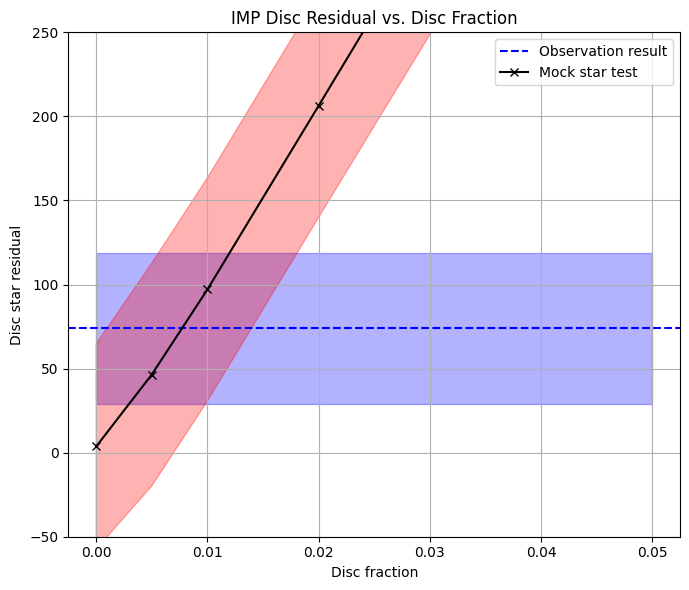

In [6]:
plot_residual_map(H_imp, xedges, yedges, "IMP", "../figures/imp_residual_map.png")
plot_disc_fraction(disc_fractions, results_imp, "IMP", "../figures/imp_disc_fraction.png")